# SAE2 :  Les vélos de Nantes

In [2461]:
# importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import ast as ast
from geopy.distance import geodesic
# importation des modules
import scipy.stats as sps


import networkx as nx


import matplotlib.pyplot as plt
%matplotlib inline
#magic
import warnings
warnings.filterwarnings('ignore')

## Le but de ce fichier est d'illustrer des contructions de graphes networkx à partir de données géolocalisée csv

### 1 Traitement des données csv :

In [2462]:
# importation du fichier csv comme un panda dataframe
capteurs=pd.read_csv("data_geolocalisationCompteur_uniques.csv", sep=';')

#on affiche les premières lignes du fichier
capteurs.head()

,Numeros,Libelle,Geolocalisation
0,"788,786,787,785",50 Otages,"47.219956631104175, -1.555035376121632"
1,"950,949",avenue de la Lib?ration,"47.19261758551086, -1.5468218693151887"
2,679,Bd Malakoff vers Gare Sud,"47.21316284797035, -1.5359421578632508"
3,"665,664",Bonduelle,"47.21160939094489, -1.5432599939033043"
4,"744,745",Calvaire,"47.215489324621586, -1.5606018691288568"


In [2463]:
# adaptation du format des données de géolocalisation
ast.literal_eval(capteurs['Geolocalisation'][0])

(47.219956631104175, -1.555035376121632)

In [2464]:
# création de la colone Latitude
capteurs['Latitude']=capteurs['Geolocalisation'].apply(lambda x : ast.literal_eval(x)[0])

In [2465]:
# création de la colone Longitude
capteurs['Longitude']=capteurs['Geolocalisation'].apply(lambda x : ast.literal_eval(x)[1])

In [2466]:
#on affiche les premières lignes du fichier actualisé
capteurs.head()

,Numeros,Libelle,Geolocalisation,Latitude,Longitude
0,"788,786,787,785",50 Otages,"47.219956631104175, -1.555035376121632",47.219957,-1.555035
1,"950,949",avenue de la Lib?ration,"47.19261758551086, -1.5468218693151887",47.192618,-1.546822
2,679,Bd Malakoff vers Gare Sud,"47.21316284797035, -1.5359421578632508",47.213163,-1.535942
3,"665,664",Bonduelle,"47.21160939094489, -1.5432599939033043",47.211609,-1.543260
4,"744,745",Calvaire,"47.215489324621586, -1.5606018691288568",47.215489,-1.560602


In [2467]:
# Création de dataframe/dictionary plus lisibles
capteurs_lite= capteurs[['Numeros','Latitude','Longitude']].copy()


# Création d'un dictionaire, structure proche des graphes networkx
#capteurs_dict=capteurs_lite[['Numéro','Latitude','Longitude']].to_dict()

capteurs_dict = {x : [capteurs_lite.iloc[x,0],capteurs_lite.iloc[x,1], capteurs_lite.iloc[x,2]] for x in range(len(capteurs_lite['Numeros']))}
capteurs_dict

{0: ['788,786,787,785', 47.219956631104175, -1.555035376121632],
 1: ['950,949', 47.19261758551086, -1.5468218693151887],
 2: ['679', 47.21316284797035, -1.5359421578632508],
 3: ['665,664', 47.21160939094489, -1.5432599939033043],
 4: ['744,745', 47.215489324621586, -1.5606018691288568],
 5: ['994,995', 47.2211808996175, -1.5520557476514105],
 6: ['747,746', 47.235601216475615, -1.5495223616419478],
 7: ['699,89', 47.20495618318359, -1.767425435319685],
 8: ['669,668', 47.20359482806785, -1.5366316681743837],
 9: ['667,847', 47.207184415056695, -1.548628245726742],
 10: ['1041,1042', 47.252189065198046, -1.5532727474949712],
 11: ['880,881', 47.211547513955786, -1.5527808502938574],
 12: ['944,946,943,945', 47.21038195207655, -1.5439240750859649],
 13: ['742,743', 47.21165736518504, -1.5563430663233755],
 14: ['683,682', 47.20889069766999, -1.5663860901495563],
 15: ['666', 47.2083580489973, -1.5497189172153978],
 16: ['890,670', 47.19812739474562, -1.5422919798047263],
 17: ['672,673

In [2468]:
capteurs_lite.head()

,Numeros,Latitude,Longitude
0,"788,786,787,785",47.219957,-1.555035
1,"950,949",47.192618,-1.546822
2,679,47.213163,-1.535942
3,"665,664",47.211609,-1.543260
4,"744,745",47.215489,-1.560602


### 2 Création d'un graphe en format networkx

In [2469]:
# proposition de dictionaire de position pour le tracé en networkx

def pos_graph(v):

    #on récupère les coordonnées
    x=float(v[1])
    y=float(v[2])
    
    #on peut adapter les coordonnées
    x=(x-47.20)*1000
    y=(y+1.543)*1000
    
    return np.array([x,y])

#on crée un dictionnaire de position
capteurs_pos = dict((k, pos_graph(v)) for k, v in capteurs_dict.items())

#Création d'un deuxième dictionnaire de position qui ne contient pas les positions exact mais plus adaptée pour la visualisation des index.
capteurs_pos2 = dict((k, pos_graph(v)) for k, v in capteurs_dict.items())
for i in range(len(capteurs_pos2)):

    #Condition pour compresser la zone de visualisation en rapprochant les sommets les plus éloignés
    if (capteurs_pos2[i][0]<(-40)):
        capteurs_pos2[i][0]= capteurs_pos2[i][0] * 0.35
    if (capteurs_pos2[i][1]<(-45)):
        capteurs_pos2[i][1]= capteurs_pos2[i][1] * 0.15
    if (capteurs_pos2[i][0]>(60)):
        capteurs_pos2[i][0]= capteurs_pos2[i][0] * 0.5
    if (capteurs_pos2[i][1]>(30)):
        capteurs_pos2[i][1]= capteurs_pos2[i][1] * 0.5 
    

#### 2.1 modélisation des arrêtes du graphe :


In [2470]:
#version pseudo-geodesique


G2 = nx.Graph(name = "Vélo_Nantes")
for index, row in capteurs_lite.iterrows():
    G2.add_node(index,numeros=[int(x) for x in row[0].split(',')],lat=row[1],long=row[2])

G2.nodes[0]

## table des distance
n=len(G2.nodes)
dist_table_geo=np.zeros((n,n))

for s in G2.nodes:
    for t in G2.nodes:
        dist=geodesic((G2.nodes[s]['lat'],G2.nodes[s]['long']),(G2.nodes[t]['lat'],G2.nodes[t]['long'])).km
        dist_table_geo[s,t]=dist
    
print(dist_table_geo)

#On ajoute l'arête [s,t] si il n'existe pas de sommet u tq d(s,u)+d(u,t) < 1.15 d(s,t)
for s in G2.nodes:
    for t in G2.nodes:
        if dist_table_geo[s,t]>.05 :
            add=True
            for u in G2.nodes:
                #Que fait-on ici ? Quel est l'impact du paramètre ?
                if dist_table_geo[s,u]+dist_table_geo[u,t] < 1.15* dist_table_geo[s,t] and dist_table_geo[s,u]>.05 and dist_table_geo[t,u]>.05:
                    add=False
            if add : 
                G2.add_edge(s,t,distance=dist_table_geo[s,t])
                print(s,t,dist_table_geo[s,t])


[[ 0.          3.10246218  1.63162214  1.28717319  0.65149567  0.26355049
   1.78870082 16.17558549  2.2918465   1.50061034  3.58593985  0.9503544
   1.35702457  0.92797334  1.50094506  1.35090008  2.61184077  2.11764498
   1.20994213  2.07677624  1.62118329  5.64777985  6.70515396 13.2078357
   1.36777894  1.48995014 10.58119842 14.92001907]
 [ 3.10246218  0.          2.42831272  2.12858781  2.74876089  3.20018447
   4.78308244 16.77207712  1.44415431  1.62523723  6.64086772  2.15241858
   1.98711694  2.23629891  2.33892034  1.76365616  0.70217617  0.98600469
   1.94151459  2.66900398  2.36161158  6.36609366  3.61144355 12.19603475
   3.01521081  4.45503375 13.58607667 13.9144383 ]
 [ 1.63162214  2.42831272  0.          0.58063566  1.88582699  1.51141496
   2.69830376 17.56061204  1.06500556  1.16850512  4.53288922  1.28817986
   0.67912387  1.55448825  2.35470906  1.1724352   1.7394168   1.63832271
   1.54171499  0.50182222  0.0700456   4.46550964  5.89617287 13.98367569
   0.6440837

#### 2.2 Création du graphe couleur en fonction des degrées de chaque sommets

In [2471]:
#fonction qui calcul le degré de chaque sommet

def degree(G):
    """
    Calcul le degré de chaque sommet du graphe G

    :param G : graphe networkx
    :type G : networkx.classes.graph.Graph
    :return deg : liste des degrés des sommets
    :rtype deg : list

    """
    deg=[]
    for s in G.nodes:
        deg.append(len(G[s]))
    return deg

#Affichage du degré de chaque sommet
deg=degree(G2)
for i in range(len(deg)):
    print("Degrée du sommet ",i," : ",deg[i])



Degrée du sommet  0  :  5
Degrée du sommet  1  :  3
Degrée du sommet  2  :  3
Degrée du sommet  3  :  5
Degrée du sommet  4  :  3
Degrée du sommet  5  :  4
Degrée du sommet  6  :  2
Degrée du sommet  7  :  3
Degrée du sommet  8  :  5
Degrée du sommet  9  :  4
Degrée du sommet  10  :  3
Degrée du sommet  11  :  5
Degrée du sommet  12  :  6
Degrée du sommet  13  :  5
Degrée du sommet  14  :  4
Degrée du sommet  15  :  4
Degrée du sommet  16  :  4
Degrée du sommet  17  :  6
Degrée du sommet  18  :  5
Degrée du sommet  19  :  4
Degrée du sommet  20  :  2
Degrée du sommet  21  :  3
Degrée du sommet  22  :  2
Degrée du sommet  23  :  3
Degrée du sommet  24  :  5
Degrée du sommet  25  :  3
Degrée du sommet  26  :  3
Degrée du sommet  27  :  2


### Modélisation en graphe des degrées de chaque stations avec des positions exactes des stations

Les stations aux couleurs froides correspondent aux degrées les plus faibles

Les stations aux couleurs chaudes correspondent aux degrées les plus élevés

on peut remarquer que les stations au centres du graphes sont des points de passages importants car ils sont reliés a plus de stations

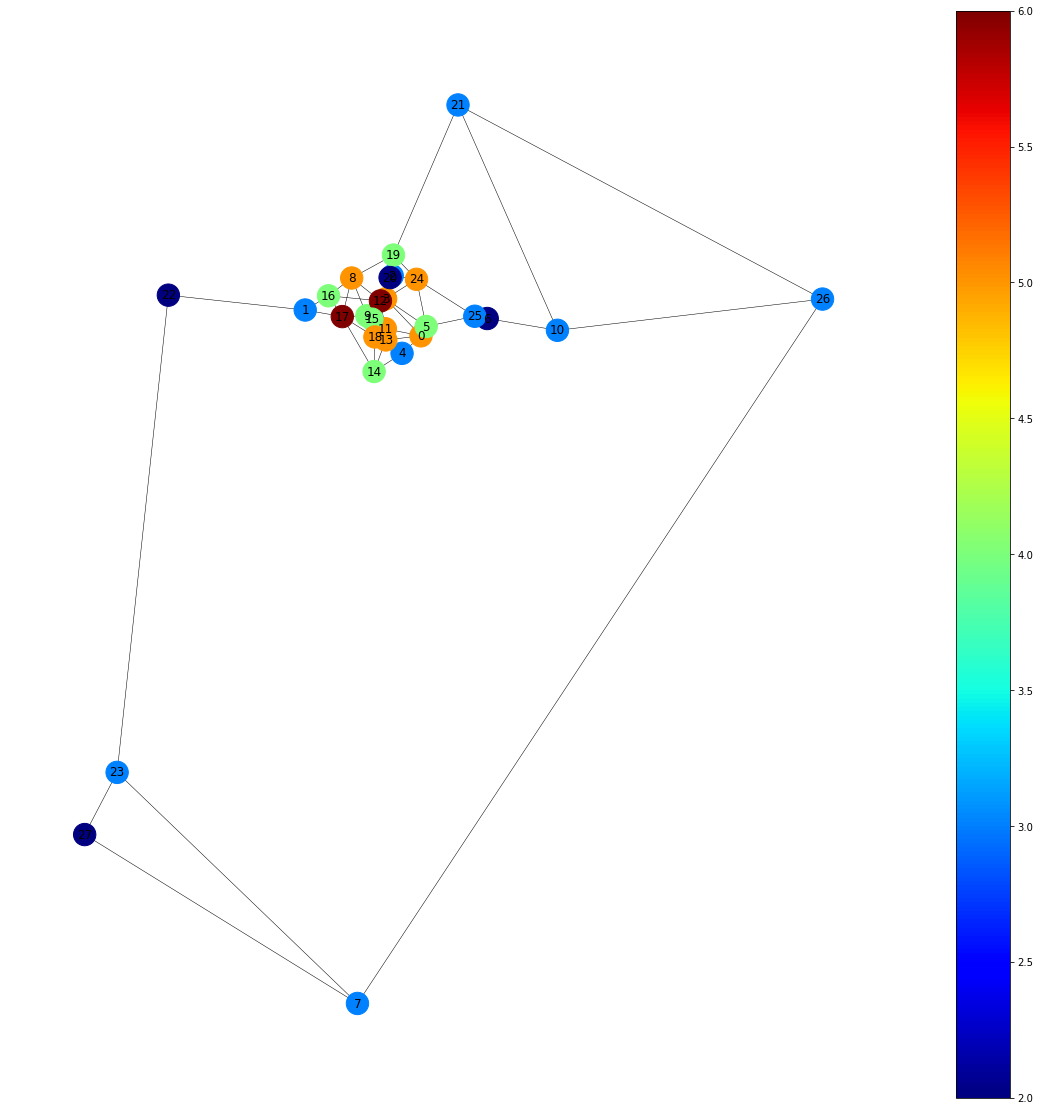

In [2472]:
cmap = plt.cm.jet

#récupération du degré de chaque sommet
deg = degree(G2)

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos, nodelist=range(len(deg)), node_color=deg, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos, font_size=font_size)

#echele de couleur
vmin = np.min(deg)
vmax = np.max(deg) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

### Modélisation en graphe des exentricités de chaque stations avec des positions inexactes des stations

cela permet de mieux voir les points au centre du graphes

Les stations aux couleurs froides correspondent aux degrée les plus faibles

Les stations aux couleurs chaudes correspondent aux degrée les plus élevés

on peut remarquer que les stations au centres du graphes sont des points de passages importants car ils sont reliés a plus de stations



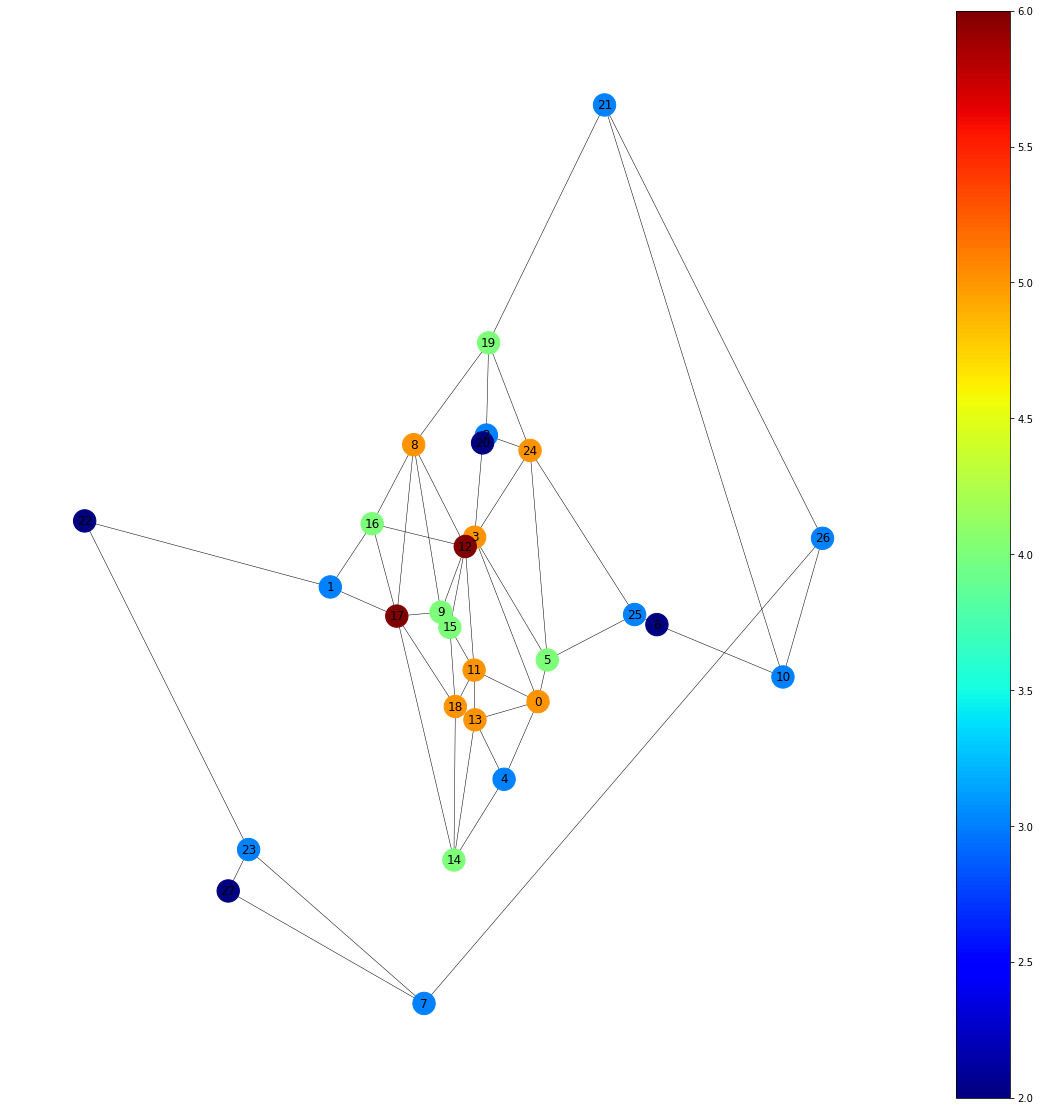

In [2473]:
cmap = plt.cm.jet

#récupération du degré de chaque sommet
deg = degree(G2)

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos2, nodelist=range(len(deg)), node_color=deg, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos2, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos2, font_size=font_size)

#echelle de couleur
vmin = np.min(deg)
vmax = np.max(deg) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

#### 2.3 Création du graphe de couleur en fonction de l'exenticité de chaque sommets

In [2474]:


def Diam_Rad(W):
    '''
    Calcule le diamètre et le rayon d'un graphe (peut-être infini)
    et la liste des excentricités des sommets

    :param W: Weight matrix 
    :type W: two dimensionnal numpy array
    :return: excentricity, diameter, and radius
    :rtype: np array of float, two float (or np.inf) (or error if negatively weighted cycle
    '''

    excentricity=[max(W[i]) for i in range(W.shape[0])]
    return [excentricity,max(excentricity),min(excentricity)]

exentricity,diameter,radius=Diam_Rad(dist_table_geo)

print("Diamètre:",diameter)
print("Rayon:",radius)
for i in range(len(exentricity)):
    print("Excentricité du sommet",i,":",exentricity[i])


Diamètre: 23.276966322028237
Rayon: 15.237391445118421
Excentricité du sommet 0 : 16.17558549185158
Excentricité du sommet 1 : 16.772077124111846
Excentricité du sommet 2 : 17.56061204283171
Excentricité du sommet 3 : 16.99885254595745
Excentricité du sommet 4 : 15.712061876409916
Excentricité du sommet 5 : 16.41432995651521
Excentricité du sommet 6 : 16.852566804078844
Excentricité du sommet 7 : 21.81261763131495
Excentricité du sommet 8 : 17.48688515521116
Excentricité du sommet 9 : 16.578594555706395
Excentricité du sommet 10 : 17.374580515883576
Excentricité du sommet 11 : 16.2779655831275
Excentricité du sommet 12 : 16.943377933839432
Excentricité du sommet 13 : 16.008917844521264
Excentricité du sommet 14 : 15.237391445118421
Excentricité du sommet 15 : 16.498264678737442
Excentricité du sommet 16 : 17.075135503424608
Excentricité du sommet 17 : 16.560914088007465
Excentricité du sommet 18 : 16.070737814145254
Excentricité du sommet 19 : 18.062381646851744
Excentricité du sommet 

### Modélisation en graphe des exentricités de chaque stations avec des positions exactes des stations

Les stations aux couleurs froides correspondent aux exentricités les plus faibles

Les stations aux couleurs chaudes correspondent aux exentricités les plus élevés

on peut remarquer que les stations éloigné du centre du graphe ont des exentricités plus élevés

cela signifis que elle ne sont pas proches de toutes les stations du graphes contrairement a celle du centre


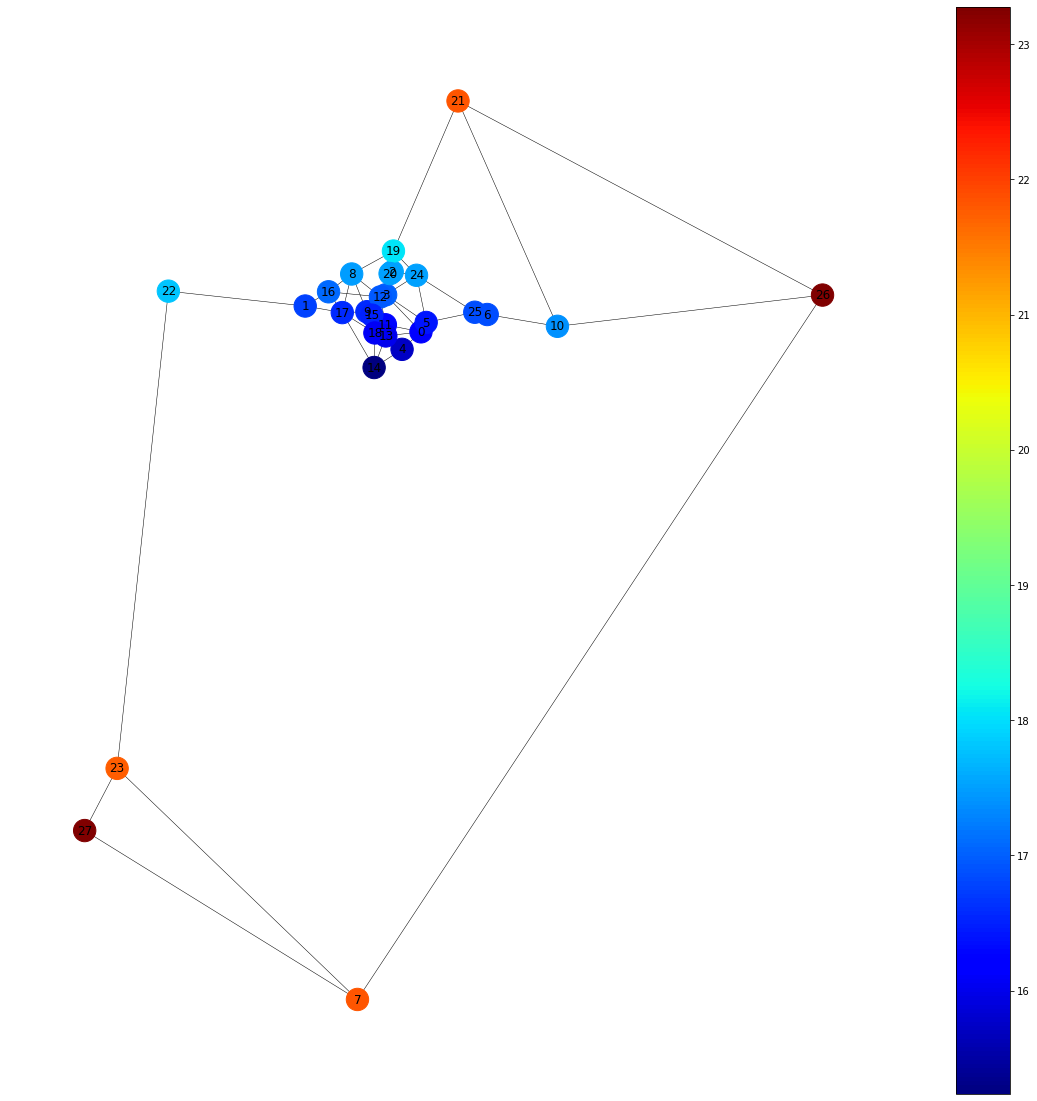

In [2475]:

cmap = plt.cm.jet

#récupération de l'exentricité de chaque sommet
excent = Diam_Rad(dist_table_geo)[0]

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos, nodelist=range(len(excent)), node_color=excent, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos, font_size=font_size)

#echelle de couleur
vmin = np.min(excent)
vmax = np.max(excent) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

### Modélisation en graphe des exentricités de chaque stations avec des positions inexactes des stations

cela permet de mieux voir les points au centre du graphes

Les stations aux couleurs froides correspondent aux exentricités les plus faibles

Les stations aux couleurs chaudes correspondent aux exentricités les plus élevés

on peut remarquer que les stations éloigné du centre du graphe ont des exentricités plus élevés

cela signifis que elle ne sont pas proches de toutes les stations du graphes contrairement a celle du centre

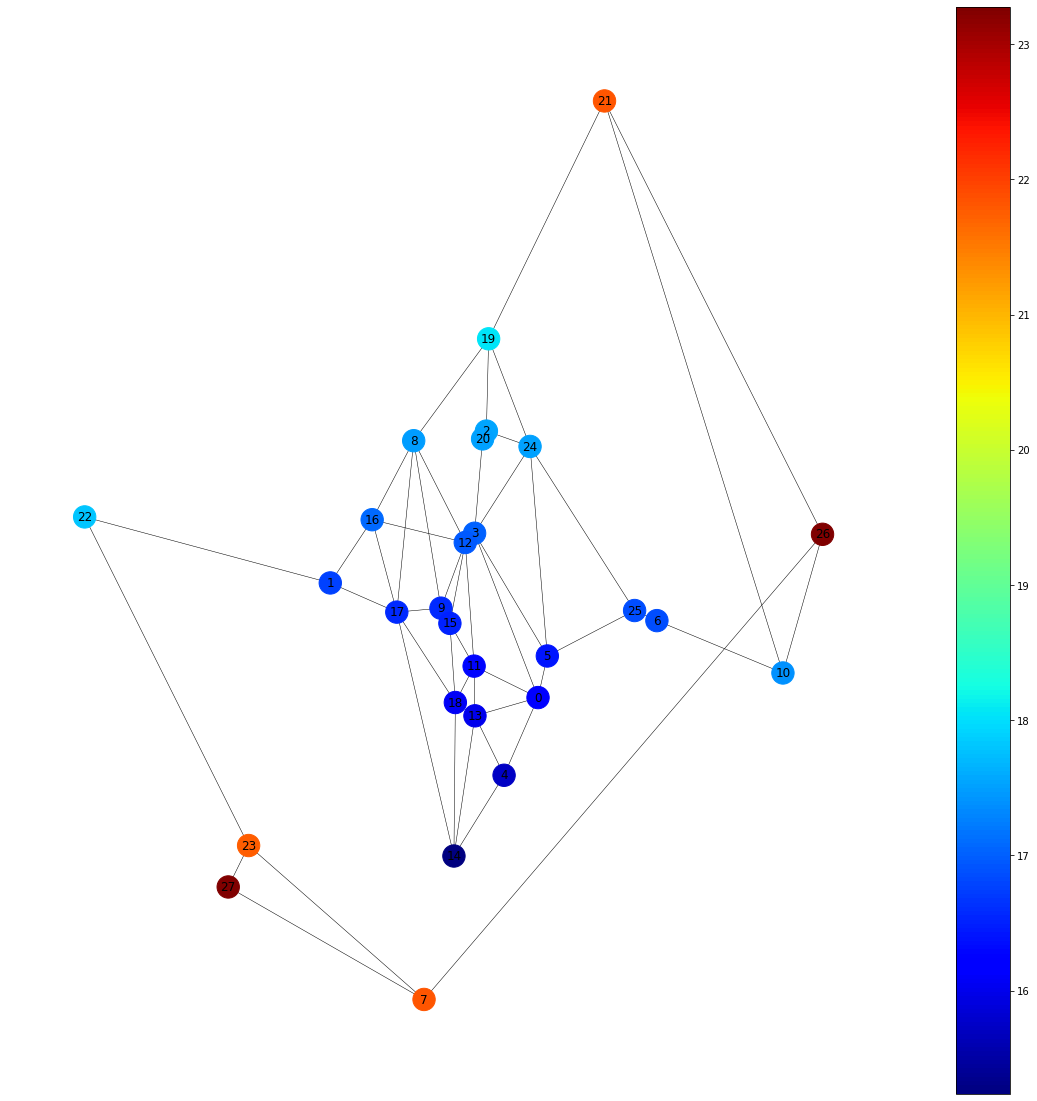

In [2476]:
cmap = plt.cm.jet

#récupération de l'exentricité de chaque sommet
excent = Diam_Rad(dist_table_geo)[0]

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos2, nodelist=range(len(excent)), node_color=excent, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos2, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos2, font_size=font_size)

#echelle de couleur
vmin = np.min(excent)
vmax = np.max(excent) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

### 3 Réalisation des fonctions qui affiche les stations visitées ainsi que le temps d'un trajet

Création d'une fonction qui nous donne le plus court chemin entre 2 stations ainsi que les stations visitées


Création d'une fonction qui nous donne toutes les distance entre chaque stations

In [2477]:
def Dijkstra(G2, s, t):
    """
    Calcule le plus court chemin entre deux sommets d'un graphe
    
    :param G2: graphe
    :type G2: networkx graph
    :param s: sommet de départ
    :type s: int
    :param t: sommet d'arrivée
    :type t: int
    :return: distance, chemin
    :rtype: float, list of int
    """
    #Initialisation
    dist = [np.inf for i in range(len(G2.nodes))]
    dist[s] = 0
    pred = [None for i in range(len(G2.nodes))]
    Q = [i for i in range(len(G2.nodes))]
    
    #Tant qu'il reste des sommets à traiter
    while Q:
        #Recherche du sommet de distance minimale
        u = min(Q, key=lambda x: dist[x])
        #Suppression du sommet de la liste
        Q.remove(u)
        #Si on a atteint le sommet d'arrivée, on arrête
        if u == t:
            break
        #Mise à jour des distances
        for v in G2[u]:
            alt = dist[u] + G2[u][v]['distance']
            if alt < dist[v]:
                dist[v] = alt
                pred[v] = u
    #Reconstruction du chemin
    chemin = [t]
    u = t
    #Tant qu'on n'est pas revenu au sommet de départ
    while u != s:
        u = pred[u]
        chemin.append(u)
    chemin.reverse()
    return dist[t], chemin


def Floyd_Warshall(G2):
    """
    Calcule le plus court chemin entre tous les sommets d'un graphe
    
    :param G2: graphe
    :type G2: networkx graph
    :return: matrice des distances
    :rtype: two dimensionnal numpy array
    """
    #Initialisation
    dist = np.zeros((len(G2.nodes), len(G2.nodes)))
    dist[:] = np.inf
    for i in range(len(G2.nodes)):
        dist[i][i] = 0
    for u in G2.nodes:
        for v in G2[u]:
            dist[u][v] = G2[u][v]['distance']
    #Algorithme de Floyd-Warshall
    for k in range(len(G2.nodes)):
        for i in range(len(G2.nodes)):
            for j in range(len(G2.nodes)):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    return dist


print("Test de la fonction Dijkstra :")

print("Trajet entre les stations 26 et 5 :")
print(Dijkstra(G2,26,5))
print(50*"--")
print("Trajet entre les stations 26 et 27 :")
print(Dijkstra(G2,26,27))
print("")

print("Test de la fonction Floyd-Warshall :")
print(Floyd_Warshall(G2))





Test de la fonction Dijkstra :
Trajet entre les stations 26 et 5 :
(10.498365195684622, [26, 10, 6, 25, 5])
----------------------------------------------------------------------------------------------------
Trajet entre les stations 26 et 27 :
(29.13924723024931, [26, 7, 27])

Test de la fonction Floyd-Warshall :
[[ 0.          3.16114971  1.88227169  1.28717319  0.65149567  0.26355049
   1.89490958 26.78331878  2.36781103  1.5285189   3.76080402  0.9503544
   1.43261174  0.92797334  1.50599782  1.37407672  2.79297356  2.17514502
   1.22390057  2.27008804  1.81222609  6.26462745  6.77259326 18.36424674
   1.42839586  1.56414898 10.76191568 20.08996126]
 [ 3.16114971  0.          2.81071176  2.21561326  2.80350465  3.42470019
   5.05605929 23.62216907  1.44609296  1.6326308   6.92195373  2.2107953
   2.07017472  2.26911569  2.551731    1.78707298  0.70217617  0.98600469
   1.97318846  2.67406812  2.74066617  6.66860753  3.61144355 15.20309704
   3.15373849  4.72529869 13.92306539 16.9

#### 3.1Fonction qui affiche pour tous les trajets possible du graphe la distance, les stations visitées ainsi que le temps

In [2478]:
def trajet(G):
    """
    Affiche le trajet entre deux stations
    puis calcule la distance et le temps de trajet entre ces deux stations
    pour un cycliste roulant à une vitesse moyenne de 20 km/h

    :param G: graphe
    :type G: networkx graph
    :param s: station de départ
    :type s: int
    :param t: station d'arrivée
    :type t: int
    """
    
    # Initialisation

    #Vitesse moyenne du cycliste en km/h
    vitesse = 20

    #affichage de la distance et du trajet entre les stations ainsi que le temps de trajet en velo
    for i in range(len(G2.nodes)):
        for j in range(len(G2.nodes)):
            #calcul de la distance et du trajet
            dist = Floyd_Warshall(G2)[i][j]
            #calcul des stations visitées
            trajet = Dijkstra(G2,i,j)[1]
            #calcul du temps de trajet en velo
            temps = dist/vitesse*60
            #ajout du temps de trajet dans une liste
            print("Distance entre les stations",i,"et",j,": {:.2f} km".format(dist))
            print("Trajet entre les stations",i,"et",j,":",trajet)
            print("Un cycliste roulant à une vitesse moyenne de {} km/h mettrait {:.1f} minutes pour parcourir cette distance".format(vitesse, temps))
            

print("Test de la fonction trajet :")

trajet(G2)

Test de la fonction trajet :
Distance entre les stations 0 et 0 : 0.00 km
Trajet entre les stations 0 et 0 : [0]
Un cycliste roulant à une vitesse moyenne de 20 km/h mettrait 0.0 minutes pour parcourir cette distance
Distance entre les stations 0 et 1 : 3.16 km
Trajet entre les stations 0 et 1 : [0, 11, 15, 9, 17, 1]
Un cycliste roulant à une vitesse moyenne de 20 km/h mettrait 9.5 minutes pour parcourir cette distance
Distance entre les stations 0 et 2 : 1.88 km
Trajet entre les stations 0 et 2 : [0, 3, 20, 2]
Un cycliste roulant à une vitesse moyenne de 20 km/h mettrait 5.6 minutes pour parcourir cette distance
Distance entre les stations 0 et 3 : 1.29 km
Trajet entre les stations 0 et 3 : [0, 3]
Un cycliste roulant à une vitesse moyenne de 20 km/h mettrait 3.9 minutes pour parcourir cette distance
Distance entre les stations 0 et 4 : 0.65 km
Trajet entre les stations 0 et 4 : [0, 4]
Un cycliste roulant à une vitesse moyenne de 20 km/h mettrait 2.0 minutes pour parcourir cette distan

#### 3.2 fonction qui récupère pour une stations toutes les distances aux autres stations

In [2479]:
def distance(G, s):
    """
    Affiche la distance entre deux stations

    :param G: graphe
    :type G: networkx graph
    :param s: station de départ
    :type s: int
    :param t: station d'arrivée
    :type t: int
    """
    
    # Initialisation

    #Vitesse moyenne du cycliste en km/h
    vitesse = 20
    listDist = []

    #affichage de la distance et du trajet entre les stations ainsi que le temps de trajet en velo
    for i in range(len(G2.nodes)):
        #calcul de la distance et du trajet
        dist = Floyd_Warshall(G2)[s][i]
        #ajout de la distance dans une liste
        listDist.append(dist)

    return listDist

print("Test de la fonction distance :")

print(distance(G2, 5))
        
          

Test de la fonction distance :
[0.263550486848139, 3.424700192347804, 1.8089290729217598, 1.2554857378451403, 0.9150461596575471, 0.0, 1.6313590971180272, 27.046869262466792, 2.33612357959373, 1.7920693908368994, 3.4972535329196544, 1.2139048897290823, 1.400924283838187, 1.191523830354328, 1.7695483085120718, 1.6376272084109784, 2.768922832976351, 2.438695504441111, 1.4874510609663019, 2.0065375578882887, 1.7805386411868072, 6.001076967595941, 7.036143742751651, 18.62779723095153, 1.1648453687417681, 1.300598497997266, 10.498365195684622, 20.3535117448574]


### Modélisation en graphe des distance a la station choisis  avec les positions exactes

Les stations aux couleurs froides correspondent aux distances les plus proches de la stations choisis

Les stations aux couleurs chaudes correspondent aux distances les plus éloigné de la stations  choisis

on peut remarquer que les stations 5 est a une faible distance de la plupart des stations sauf des stations éloignées comme la station 7



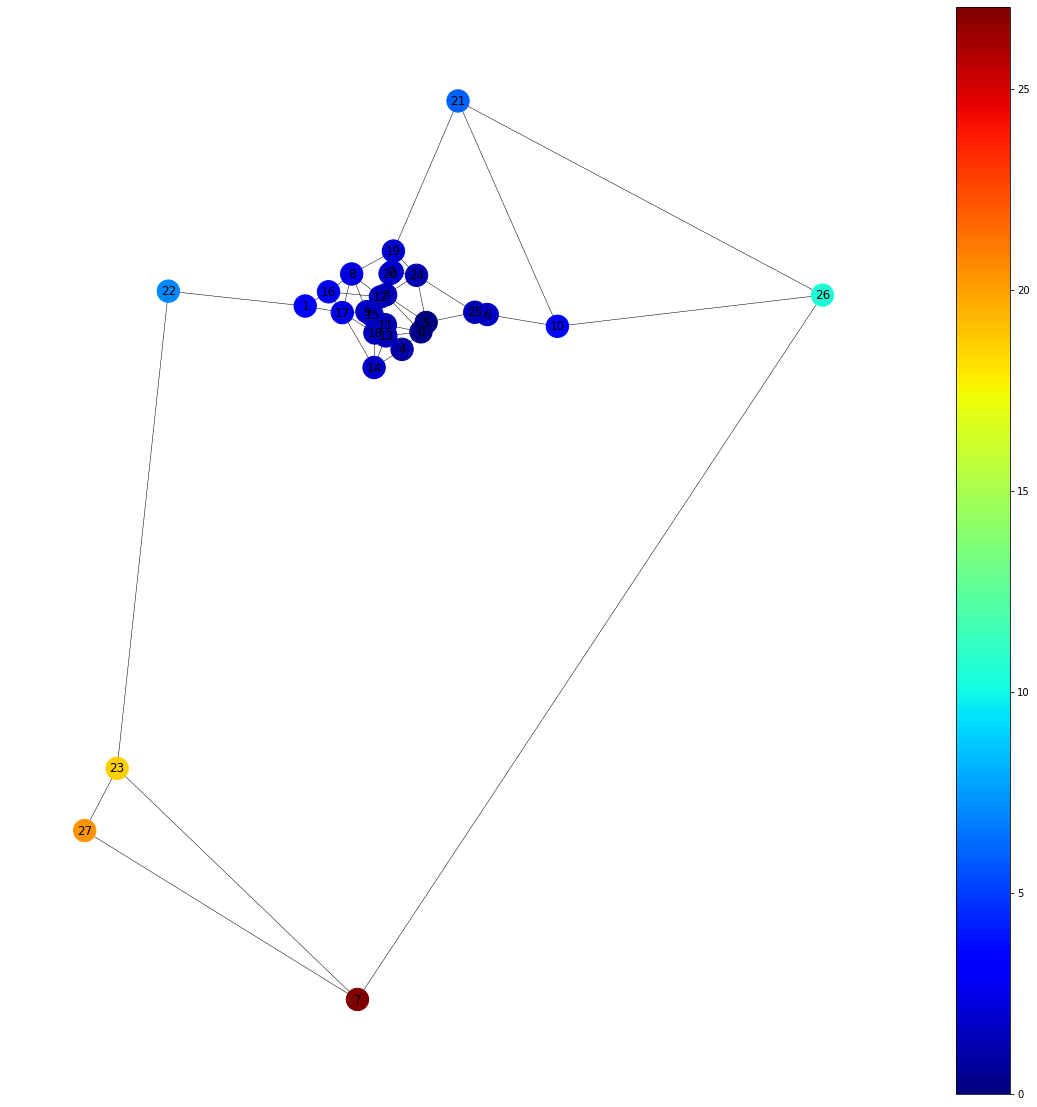

In [2480]:
cmap = plt.cm.jet

#récupération de la distance de chaque sommet
dist = distance(G2, 5)

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos, nodelist=range(len(dist)), node_color=dist, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos, font_size=font_size)

#echelle de couleur
vmin = np.min(dist)
vmax = np.max(dist) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

### Modélisation en graphe des distance a la station choisis  avec les positions inexacte des stations

cela permet de mieux voir les points au centre du graphes

Les stations aux couleurs froides correspondent aux distances les plus proches de la stations choisis

Les stations aux couleurs chaudes correspondent aux distances les plus éloigné de la stations  choisis

on peut remarquer que les stations 5 est a une faible distance de la plupart des stations sauf des stations éloignées comme la station 7

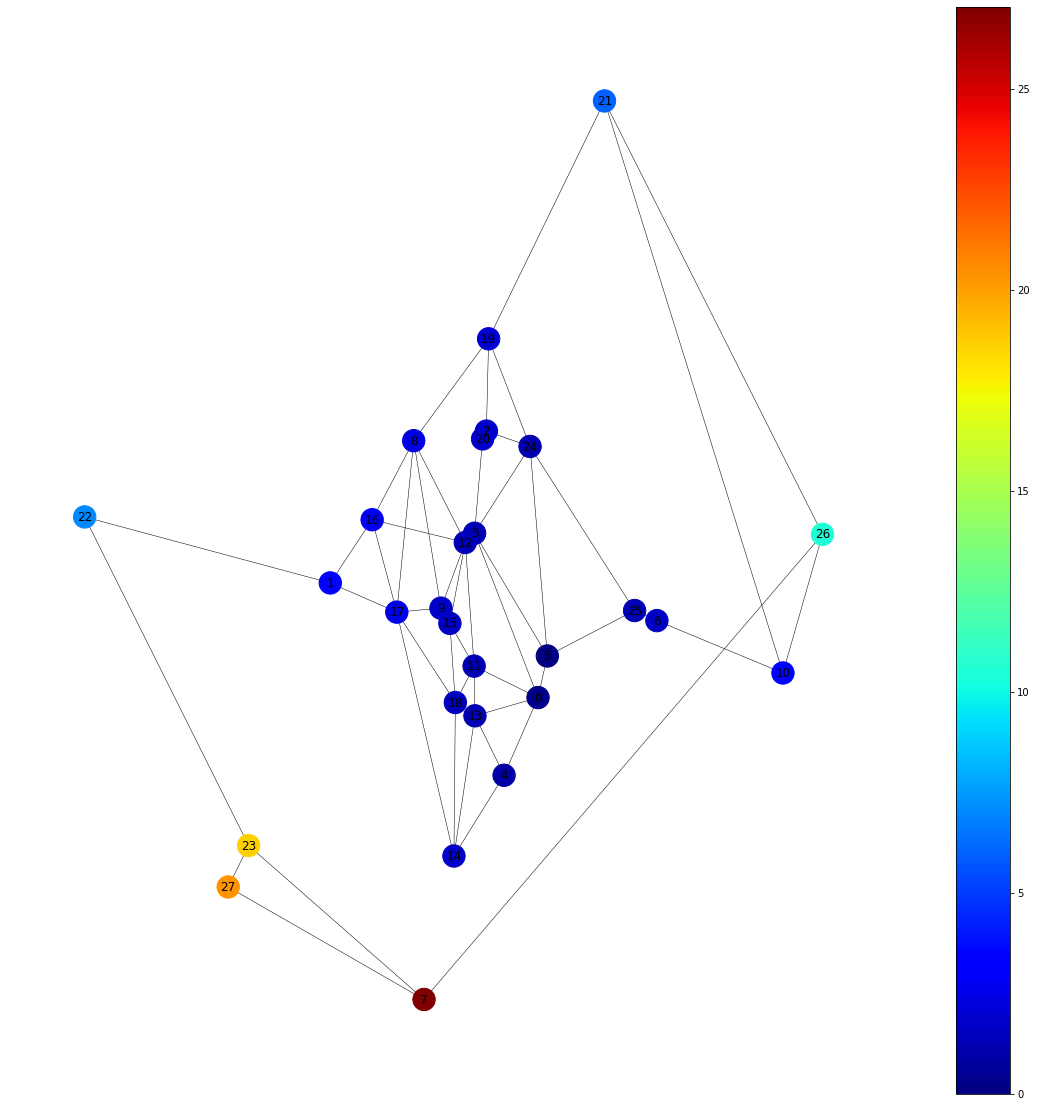

In [2481]:
cmap = plt.cm.jet

#récupération de la distance de chaque sommet
dist = distance(G2, 5)

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos2, nodelist=range(len(dist)), node_color=dist, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos2, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos2, font_size=font_size)

#echelle de couleur
vmin = np.min(dist)
vmax = np.max(dist) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

#### 3.3fonction qui calcul le temps de trajet pour aller de la station choisi a toutes les autres stations du graphe



In [2482]:
def tempsDeTrajet(G, s):
    """
    Affiche le temps de trajet entre deux stations
    pour un cycliste roulant à une vitesse moyenne de 20 km/h

    :param G: graphe
    :type G: networkx graph
    :return: liste des temps de trajet
    :rtype: list
    """

    
    vitesse = 20
    listTemps = []

    for i in range(len(G2.nodes)):
        #calcul de la distance et du trajet
        dist = Floyd_Warshall(G2)[s][i]
        #calcul des stations visitées
        temps = dist/vitesse*60
        #ajout du temps de trajet dans une liste
        listTemps.append(temps)
    
    return listTemps

print("Test de la fonction tempsDeTrajet :")
print(tempsDeTrajet(G2, 0))



Test de la fonction tempsDeTrajet :
[0.0, 9.483449116498996, 5.646815067052108, 3.8615195689661745, 1.9544870184282246, 0.7906514605444169, 5.684728751898499, 80.34995632685596, 7.103433094211944, 4.585556711966281, 11.28241205930338, 2.8510632086428296, 4.297835206945315, 2.783920030518567, 4.517993464991799, 4.122230164688518, 8.378920694577005, 6.525435052778916, 3.6717017223544883, 6.810264134209283, 5.436678278991176, 18.793882363332237, 20.317779767710537, 55.09274023231017, 4.2851875667697215, 4.692446954536216, 32.285747047598285, 60.269883774027775]


### Modélisation en graphe du temps de trajet a la station choisis avec les positions exacte des stations

Les stations aux couleurs froides correspondent aux temps de trajets les plus faibles de la stations choisis

Les stations aux couleurs chaudes correspondent aux temps de trajets les plus élevés de la stations  choisis

On peut remarquer que la station 0 nous permet facilement et dans un temps raisonnable d'acceder a la plupart des stations 

Cependant on peut voir que la station 7 est vraiment éloigné car elle est 80 minutes en velo de la station 0

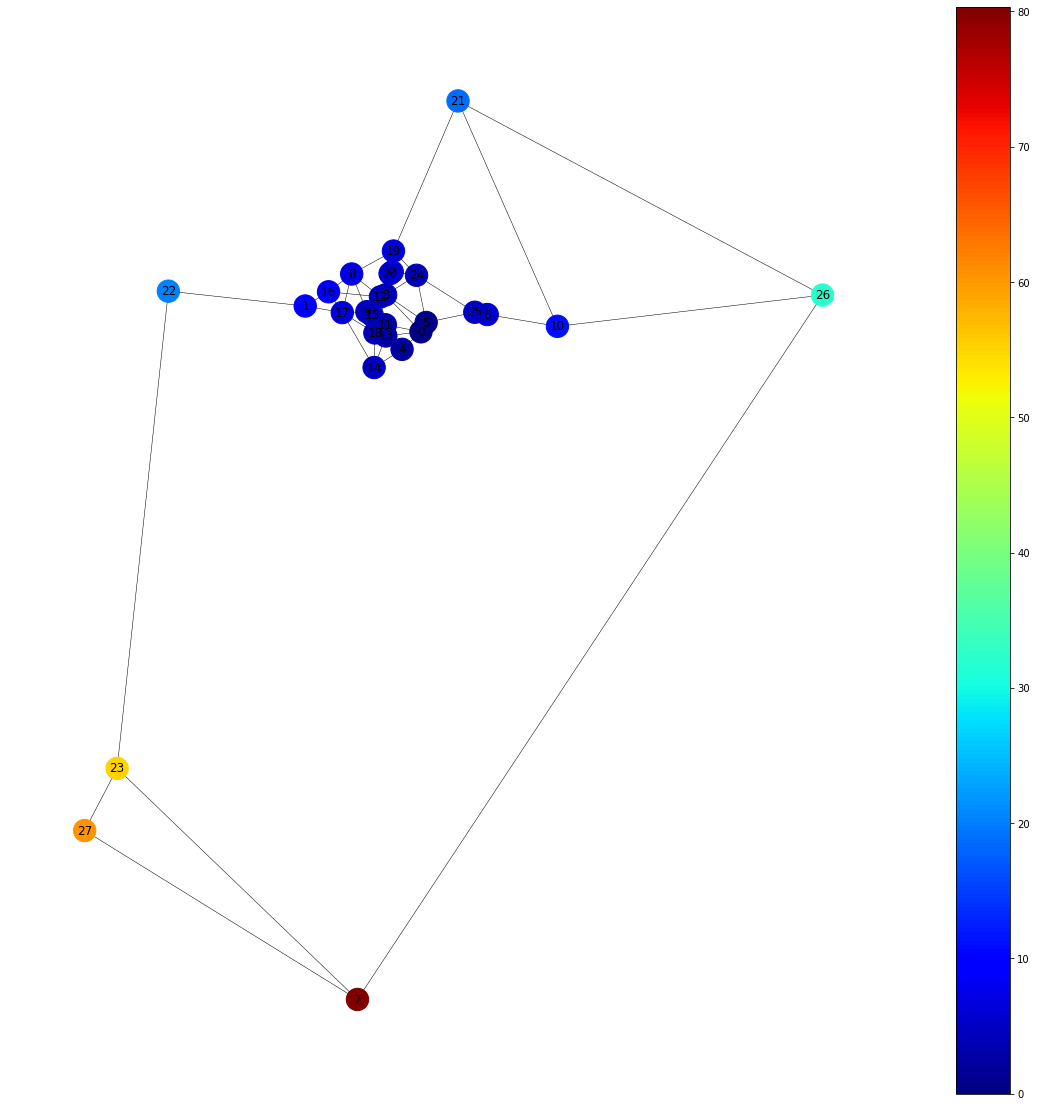

In [2483]:
cmap = plt.cm.jet

#récupération du temps de trajet de chaque sommet
temps = tempsDeTrajet(G2, 0)

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos, nodelist=range(len(temps)), node_color=temps, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos, font_size=font_size)

#echelle de couleur
vmin = np.min(temps)
vmax = np.max(temps) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()

### Modélisation en graphe des distance a la station choisis  avec les positions inexacte des stations

cela permet de mieux voir les points au centre du graphes

Les stations aux couleurs froides correspondent aux distances les plus proches de la stations choisis

Les stations aux couleurs chaudes correspondent aux distances les plus éloigné de la stations choisis

On peut remarquer que la station 0 nous permet facilement et dans un temps raisonnable d'acceder a la plupart des stations 

Cependant on peut voir que la station 7 est vraiment éloigné car elle est 80 minutes en velo de la station 0

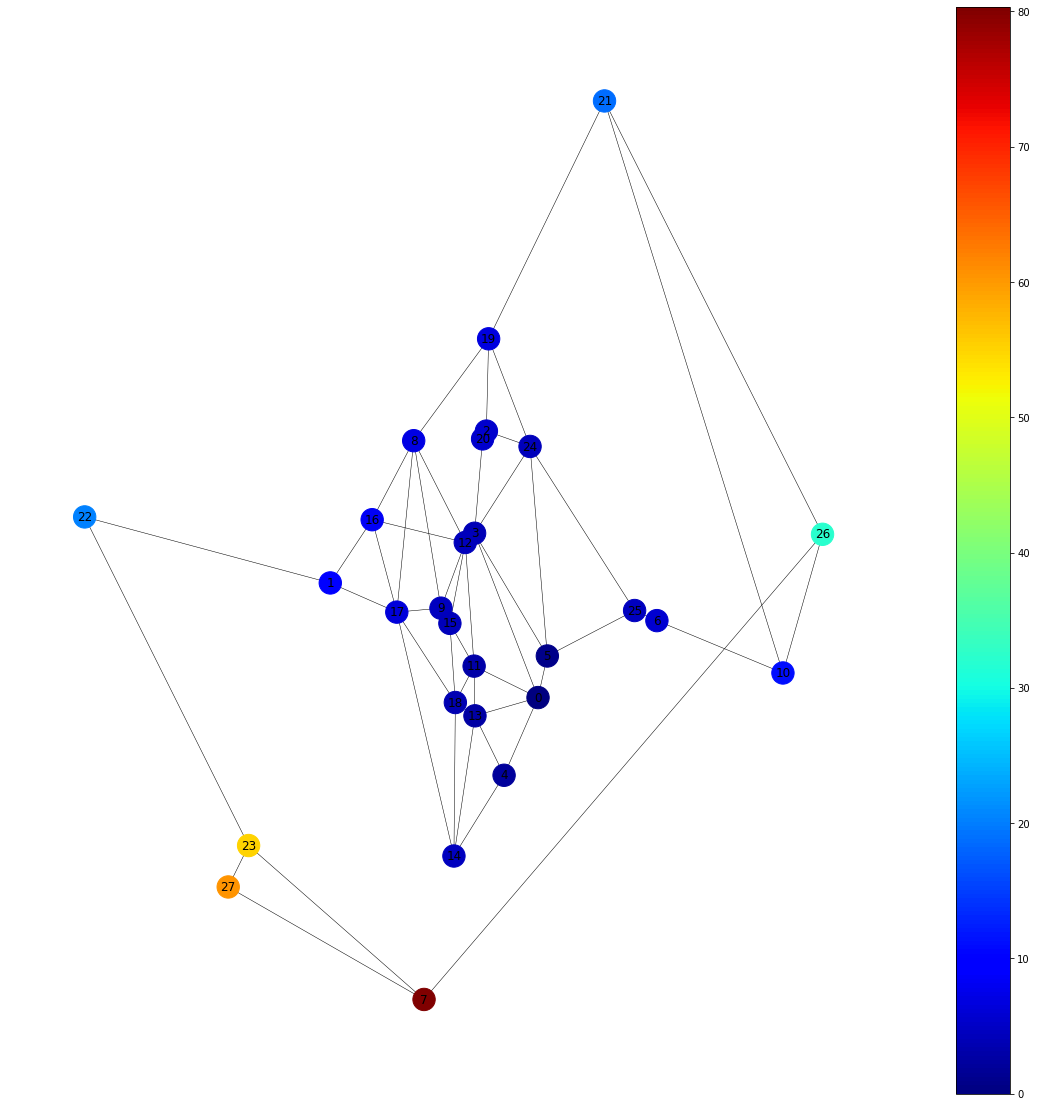

In [2484]:
cmap = plt.cm.jet

#récupération du temps de trajet de chaque sommet
temps = tempsDeTrajet(G2, 0)

plt.figure(figsize=(20,20))

#paramètres d'affichage
node_size = 500
font_size = 12
edge_width = 0.5

#on affiche le graphe
nx.draw_networkx_nodes(G2, capteurs_pos2, nodelist=range(len(temps)), node_color=temps, cmap=cmap, node_size=node_size)
nx.draw_networkx_edges(G2, capteurs_pos2, width=edge_width)
nx.draw_networkx_labels(G2, capteurs_pos2, font_size=font_size)

#echelle de couleur
vmin = np.min(temps)
vmax = np.max(temps) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.axis("off")
plt.show()